<a href="https://colab.research.google.com/github/Erikellerx/Projects_in_MLAI/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Oct  7 04:48:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Research of Framework**

I first went through some documentation of PyTorch and some example of how to create a NN using Pytorch. Since I am using google colab, there is no need for me to install PyTorch and figure out the environment setup. However, I still leave a link below about installation.  

Link: https://pytorch.org/docs/stable/index.html  https://pytorch.org/ https://www.kaggle.com/code/kanncaa1/pytorch-tutorial-for-deep-learning-lovers/notebook


Since I want to use MNIST dataset for this project, I looked though some basic of MNIST and how to load it. I could, therefore, know how much of a performance I could achieve using 2 layer NN. 

Link: http://yann.lecun.com/exdb/mnist/ https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

Overall, I need torch.nn to create my NN network structure and loss function, torchvision.datasets to load my MNIST dataset, torch.optim to define my optimizer, torchvision.transforms.ToTensor to transfer my data into tensor. 




In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**load and split dataset**

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

val_data, test_data = torch.utils.data.random_split(test_data, [5000,5000])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



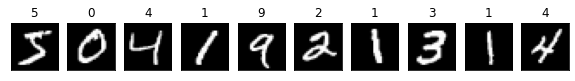

In [4]:
fig, axes = plt.subplots(ncols=10, sharex=False, 
    sharey=True, figsize=(10, 4))
for i in range(10):
    x, y = train_data[i]
    axes[i].set_title(y)
    axes[i].imshow(x.view(28,28), cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

Text(0, 0.5, 'Count')

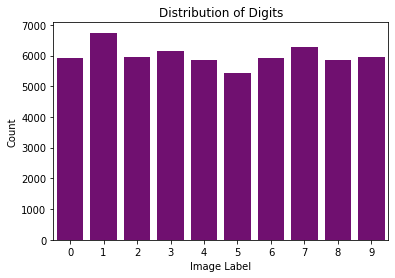

In [5]:
labels = [ each[1] for each in train_data]
sns.countplot(x=labels, color="purple")
plt.title("Distribution of Digits")
plt.xlabel("Image Label")
plt.ylabel("Count")

# Create NN and Train


**Hyperparameters**

In [6]:
epoch = 10
batch = 64 
lr = 0.01 
momentum = 0.9

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = 1000, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 1000, shuffle = True)

**define out neural network**

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(28 * 28, 256)
    self.linear2 = nn.Linear(256, 10)
    self.relu = nn.ReLU()


  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return x

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
criterion  = nn.CrossEntropyLoss()

In [10]:
epochlist = [e for e in range(epoch)]
trainLoss = []
trainAcc = []
valLoss = []
valAcc = []


for e in range(epoch):
  #Train
  
  correct = 0
  totalLoss = 0
  model.train()
  for i, (x, y) in enumerate(train_loader):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()

    y_pred = model(x.view(-1, 28*28))
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    label = y_pred.argmax(dim=1, keepdim=True)
    correct += label.eq(y.view_as(label)).sum().item()
    totalLoss += loss.item()

    if i % 50 == 0:
      print(f"Training...epoch: {e}, loss: {loss.item()}")
  trainAcc.append(correct / len(train_loader.dataset))
  trainLoss.append(totalLoss / len(train_loader))
  

  #Validation
  correct = 0
  loss = 0
  model.eval()
  with torch.no_grad():
    for i, (x, y) in enumerate(val_loader):
      x, y = x.to(device), y.to(device)
      y_pred = model(x.view(-1,28*28))
      loss += criterion(y_pred, y).item()
      label = y_pred.argmax(dim=1, keepdim=True)
      correct += label.eq(y.view_as(label)).sum().item()

  loss /= len(val_loader)
  acc = correct / len(val_loader.dataset)
  print(f"Validation...epoch: {e}, loss : {loss}, acc: {acc}")
  valAcc.append(acc)
  valLoss.append(loss)


Training...epoch: 0, loss: 2.288153648376465
Training...epoch: 0, loss: 1.3703818321228027
Training...epoch: 0, loss: 0.5616044402122498
Training...epoch: 0, loss: 0.541380763053894
Training...epoch: 0, loss: 0.43863561749458313
Training...epoch: 0, loss: 0.26365959644317627
Training...epoch: 0, loss: 0.3323659300804138
Training...epoch: 0, loss: 0.3026951849460602
Training...epoch: 0, loss: 0.3872958719730377
Training...epoch: 0, loss: 0.2580329477787018
Training...epoch: 0, loss: 0.33032938838005066
Training...epoch: 0, loss: 0.2669133245944977
Training...epoch: 0, loss: 0.5156908631324768
Training...epoch: 0, loss: 0.4410970211029053
Training...epoch: 0, loss: 0.42949673533439636
Training...epoch: 0, loss: 0.36751893162727356
Training...epoch: 0, loss: 0.2242804914712906
Training...epoch: 0, loss: 0.22974298894405365
Training...epoch: 0, loss: 0.3636850118637085
Validation...epoch: 0, loss : 0.25003641545772554, acc: 0.932
Training...epoch: 1, loss: 0.2083820402622223
Training...epo

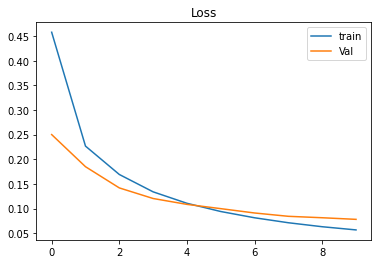

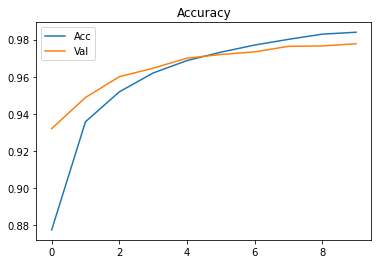

In [11]:
plt.title("Loss")
plt.plot(epochlist, trainLoss, label = "train" )
plt.plot(epochlist, valLoss, label = "Val")
plt.legend()
plt.show()

plt.title("Accuracy")
plt.plot(epochlist, trainAcc, label = "Acc" )
plt.plot(epochlist, valAcc, label = "Val" )
plt.legend()
plt.show()

In [12]:
correct = 0
model.eval()
for x, y in test_loader:
  x,y = x.to(device), y.to(device)
  y_pred = model(x.view(-1,28 * 28))
  label = y_pred.argmax(dim = 1)
  correct += label.eq(y.view_as(label)).sum().item()

acc = correct / len(test_loader.dataset)
print(f"Testing Accuracy: {acc}")

Testing Accuracy: 0.9772


**Hyperparameters**

**epoch**: I initialize set epoch to 10, which doesn't show a sign of overfitting bese on the graph above. However, I also tried 20 and there is clearly overfitting start epoch 15 and so. The sweet spot of epoch should be around 8~12. 

**Batch**: I set batch to 64. I initially set my batch to a larger number, which lead a very poor training accuracy. I think this is because our gradient had stucked into a local minimum. 

**lr (Learning rate)**: I initialize set my lr to 0.001. However, the accuracy within 10 epoch could surpass 90%. This is a sign of underfitting. Therefore, I raise my lr to 0.01 and my model converge fairly quickly and result to a high testing and validation accuracy.

**Momentum**: I didn't change much in terms of momentum. I set this one to 0.9 as suggested. 

I didn't use any form of regularization. This is because my model doesn't show a quick overfitting and, therefore, using regularization isn't optimal. 

There are two hidden layer in my NN and both of them are nn.Linear. I used ReLU in between to keep this simple. In my two hidden layer, I down scale my 784 features into 256, then to 10. The final 10 will correspond my targeted output. I used SDG + momentum as my optimizer. I also tried Adam, Adagrad, and Adadelta. However, I think SDG is good enough for this task, whereas other three optimizers mention above could lead to a faster converging (faster overfitting of course). 


# Decision Tree

In [13]:
from sklearn import tree 
from sklearn.metrics import accuracy_score

In [14]:
train_data = datasets.MNIST('./data', train=True, download=True).data.numpy()
test_data = datasets.MNIST('./data', train=False, download=True).data.numpy()

train = []
for each in train_data:
  train.append(each.flatten())

test = []
for each in test_data:
  test.append(each.flatten())

train_data = np.array(train).astype(float)
test_data = np.array(test).astype(float)

train_target = datasets.MNIST('./data', train=True, download=True).targets.numpy()
test_target = datasets.MNIST('./data', train=False, download=True).targets.numpy()

model = tree.DecisionTreeClassifier()
model = model.fit(train_data, train_target)

pred = model.predict(test_data)
dtacc = accuracy_score(pred, test_target)

print(f"Decision Tree Acc: {dtacc}")

Decision Tree Acc: 0.8767


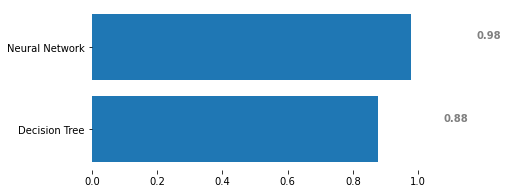

In [15]:
fig, ax = plt.subplots(figsize =(6, 3))

model = ("Decision Tree", "Neural Network")
score = (dtacc, acc)
ax.barh(model, score)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')


Result comparison shows a clearly sign of the fact that NN is outperform Decision Tree in MNIST dataset. The accuracy difference is about 10% in my implementation. The reason why NN perform so good is that NN could capture better pattern of 10 class classification. Decision Tree, however, could only draw straight lines in feature space. Therefore, couldn't capture such variance of pattern and difference between each class.  